## Notebook Description
This notebook is dedicated to basic EDA on the clean data read in from the `clean_data` folder. It will look at the data in one dataframe, then split the data into two dataframes (one for each Subreddit), to look at the data independently.

In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
df = pd.read_csv('../raw_data/reddit.csv')
df.head()

,title,selftext,subreddit,created_utc
0,We’d comfort in the back country? Check these ...,NaN,backpacking,1646363240
1,Finding water on the trail,"Yo waddup every1, I was wondering how I might ...",backpacking,1646363128
2,Pacing Tips,Hey y'all! I've just been backpacking in Mexic...,backpacking,1646359058
3,Fes Morocco 5 hr layover,[removed],backpacking,1646358302
4,"Hi all, I have a favor to ask. I designed a mo...",NaN,backpacking,1646356995


In [4]:
df.isnull().sum()

title             0
selftext       1420
subreddit         0
created_utc       0
dtype: int64

In [5]:
# Replacing null values with blank, as the missing values are text.
df['selftext'] = df['selftext'].fillna('')
df.isnull().sum()

title          0
selftext       0
subreddit      0
created_utc    0
dtype: int64

## EDA on Original DF

In [6]:
df.shape

(3999, 4)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        3999 non-null   object
 1   selftext     3999 non-null   object
 2   subreddit    3999 non-null   object
 3   created_utc  3999 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 125.1+ KB


In [8]:
df.describe()

,created_utc
count,3.999000e+03
mean,1.636892e+09
std,9.196830e+06
min,1.614219e+09
25%,1.630080e+09
50%,1.641596e+09
75%,1.643916e+09
max,1.646363e+09


In [9]:
df.groupby('subreddit')['selftext'].count()

subreddit
backpacking     1999
ultrarunning    2000
Name: selftext, dtype: int64

### Analyze the Timing of Reddit Submmissions

In [11]:
# Length of time between first and last post in df
pd.to_datetime(df['created_utc'].max(), unit='s') - pd.to_datetime(df['created_utc'].min(), unit='s')

Timedelta('372 days 01:04:12')

#### Creating New Time Columns

In [12]:
# Creates EST time from UTC
df['created_est'] = pd.to_datetime(df['created_utc'], unit='s')


# Returns only yyy-mm-dd format from `created_est`
# Source: # https://stackoverflow.com/questions/38516251/valueerror-cannot-cast-datetimeindex-to-dtype-datetime64us
df['date_posted'] = df['created_est'].dt.to_period('M').apply(lambda d: pd.to_datetime(str(d)))


# Creates a Month Name column
df['month_name'] = df['date_posted'].dt.month_name()


# Converts month_name to type CategoricalDtype
# Source https://towardsdatascience.com/ridgeline-plots-the-perfect-way-to-visualize-data-distributions-with-python-de99a5493052

from pandas.api.types import CategoricalDtype

cat_month = CategoricalDtype(
    ['January', 'February', 'March', 'April', 'May', 'June',
     'July', 'August', 'September', 'October', 'November', 'December']
)

df['month_name'] = df['month_name'].astype(cat_month)

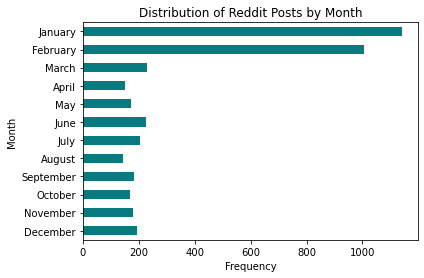

In [14]:
# Reddit Posts by Month

df.sort_values('month_name',ascending=False).groupby('month_name', sort=False)['date_posted'].count().plot.barh(color = '#097a80')
plt.title("Distribution of Reddit Posts by Month")
plt.xlabel("Frequency")
plt.ylabel("Month")
plt.savefig("../graphics/Distribution_of_Reddit_Posts_by_month.jpg", bbox_inches="tight", dpi=100); #save as jpg;;

<Figure size 432x288 with 0 Axes>

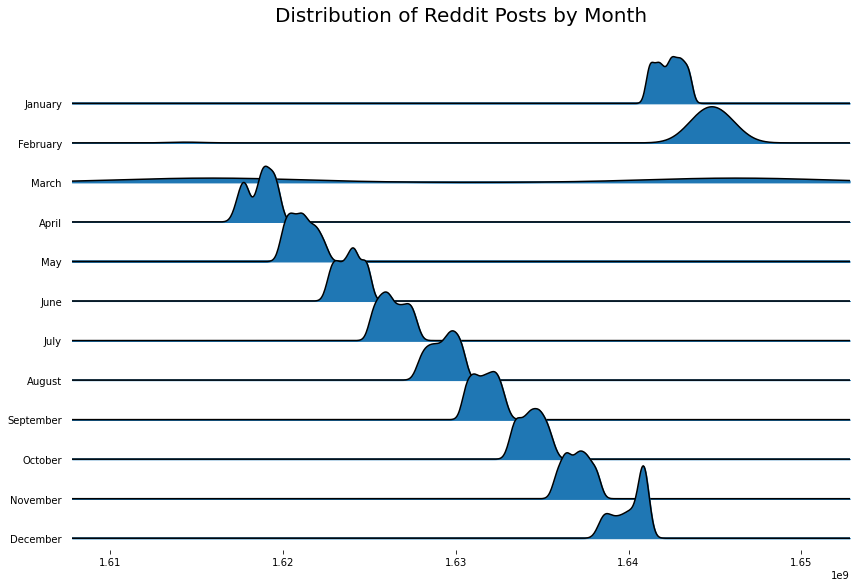

In [21]:
from joypy import joyplot

plt.figure()

joyplot(
    data=df[['created_utc', 'month_name']], 
    by='month_name',
    figsize=(12, 8),
    overlap=1
)
plt.title('Distribution of Reddit Posts by Month', fontsize=20)
plt.ylabel('Month');

## Baseline Model

In [40]:
# Baseline model
df['subreddit'].value_counts(normalize=True)

ultrarunning    0.500125
backpacking     0.499875
Name: subreddit, dtype: float64

## Set up for CountVectorizer

In [23]:
# Set up for CountVectorizer

X = df['title']
y = df['subreddit']

In [25]:
# Train/Test/Split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [27]:
# Instantiate a CountVectorizer with the default hyperparameters and stop_words
cvec = CountVectorizer(stop_words='english')

# Fit the vectorizer on my corpus
cvec.fit(X_train)

CountVectorizer(stop_words='english')

In [28]:
# Transform the corpus
X_train = cvec.transform(X_train)

# Transform test
X_test = cvec.transform(X_test)

In [29]:
# View some of the feature_names

cvec.get_feature_names()[1000:1010]

['chews',
 'chi',
 'chic',
 'chicago',
 'chicagoland',
 'chicken',
 'children',
 'chile',
 'chill',
 'chiloé']

In [30]:
X_train_df = pd.DataFrame(X_train.todense(),
                         columns=cvec.get_feature_names())

In [31]:
X_train_df.head()

,000,000ft,000m,01,02,03,05,0⁰c,10,100,...,لعبة,للاندرويد,مباشر,مجانا,अन,एक,कर,नप,महल,सप
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## EDA on CountVectorized Title

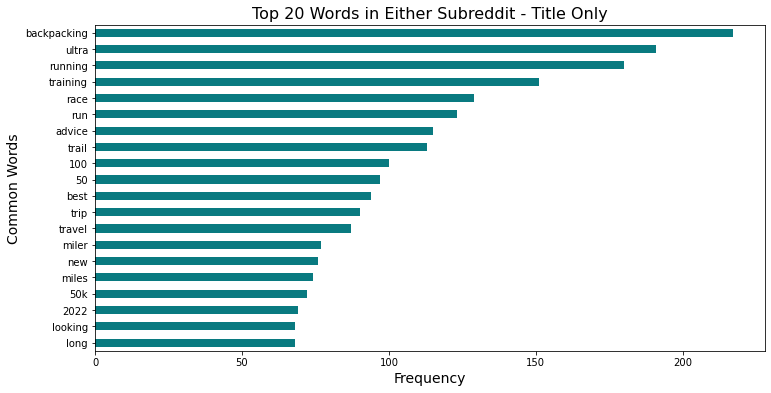

In [32]:
# Top 20 occurring words in either subreddits - using only Title column

X_train_df.sum(numeric_only=True).sort_values(ascending=True).tail(20).plot.barh(figsize=(12,6), color = '#097a80')
plt.xlabel('Frequency', fontdict= {'fontsize':14})
plt.ylabel('Common Words', fontdict= {'fontsize':14})
plt.title('Top 20 Words in Either Subreddit - Title Only', fontdict = {'fontsize':16})
plt.savefig("../graphics/Top_20_words_either_subreddit_title_only.jpg", bbox_inches="tight", dpi=100); #save as jpg

## Splitting Dataframe by Subreddits

In [33]:
df_backpacking = df[df['subreddit'] == 'backpacking']
df_backpacking.shape

(1999, 7)

In [34]:
df_ultrarunning = df[df['subreddit'] == 'ultrarunning']
df_ultrarunning.shape

(2000, 7)

In [35]:
df_ultrarunning.head()

,title,selftext,subreddit,created_utc,created_est,date_posted,month_name
1999,Narrow Feet Trail Shoe Recs,"Hi Y'all, \n\nJust wanted to poll the crowd of...",ultrarunning,1646336942,2022-03-03 19:49:02,2022-03-01,March
2000,Shoe sizing,"I typically wear a 12.5, does any one buy shoe...",ultrarunning,1646321962,2022-03-03 15:39:22,2022-03-01,March
2001,Advice: Sledge/pulk design for a winter ultram...,"I'm preparing for my first winter ultra, and a...",ultrarunning,1646270995,2022-03-03 01:29:55,2022-03-01,March
2002,venting - dumb clinics,I put a hard stop on my training with some con...,ultrarunning,1646253091,2022-03-02 20:31:31,2022-03-01,March
2003,Phantom Stress Pains,Hey everyone - I had a stress reaction this ti...,ultrarunning,1646191139,2022-03-02 03:18:59,2022-03-01,March


### CountVectorize & EDA for Backpacking Subreddit

In [36]:
cvec = CountVectorizer(stop_words = 'english')
cvec.fit(df_backpacking['title'])
csr = cvec.transform(df_backpacking['title'])
df_backpacking = pd.DataFrame(csr.todense(), columns = cvec.get_feature_names())

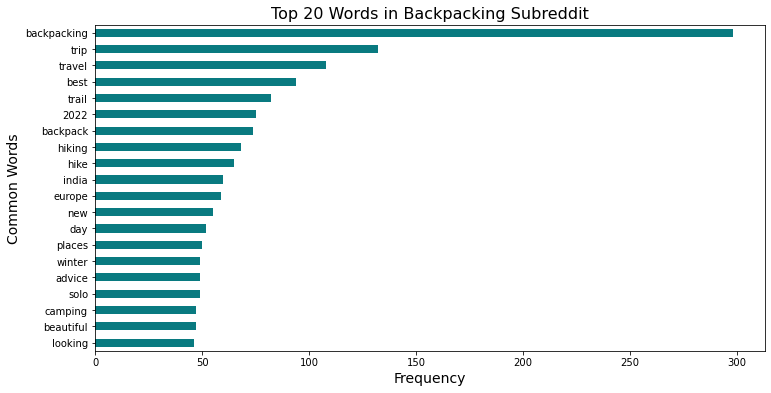

In [37]:
# Top 20 occurring words in Backpacking subreddit

df_backpacking.sum(numeric_only=True).sort_values(ascending=True).tail(20).plot.barh(figsize=(12,6), color = '#097a80')
plt.xlabel('Frequency', fontdict= {'fontsize':14})
plt.ylabel('Common Words', fontdict= {'fontsize':14})
plt.title('Top 20 Words in Backpacking Subreddit', fontdict = {'fontsize':16})
plt.savefig("../graphics/Top_20_words_Backpacking.jpg", bbox_inches="tight", dpi=100); #save as jpg

### CountVectorize & EDA for Ultrarunning Subreddit

In [38]:
cvec = CountVectorizer(stop_words = 'english')
cvec.fit(df_ultrarunning['title'])
csr = cvec.transform(df_ultrarunning['title'])
df_ultrarunning = pd.DataFrame(csr.todense(), columns = cvec.get_feature_names())

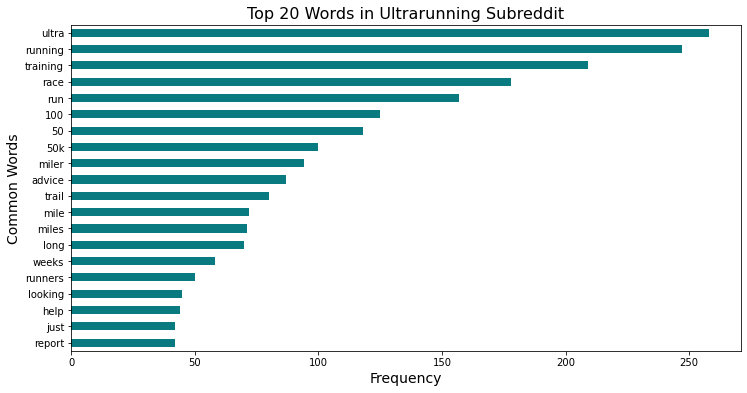

In [39]:
# Top 20 occurring words in Ultrarunning subreddit

df_ultrarunning.sum(numeric_only=True).sort_values(ascending=True).tail(20).plot.barh(figsize=(12,6), color = '#097a80')
plt.xlabel('Frequency', fontdict= {'fontsize':14})
plt.ylabel('Common Words', fontdict= {'fontsize':14})
plt.title('Top 20 Words in Ultrarunning Subreddit', fontdict = {'fontsize':16})
plt.savefig("../graphics/Top_20_words_Ultrarunning.jpg", bbox_inches="tight", dpi=100); #save as jpg